In [1]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]


In [2]:
data_dir='../data/multi_nli'
tmp_dir='../tmp/multi_nli'

# Fetch the problem
problem = problems.problem("multi_nli")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
problem.generate_data(data_dir, tmp_dir)

# Get the encoders from the problem
encoders = problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

INFO:tensorflow:Skipping generator because outputs files exists at ['../data/multi_nli/multi_nli-unshuffled-train-00000-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00001-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00002-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00003-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00004-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00005-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00006-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00007-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00008-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00009-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00010-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00011-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00012-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-00013-of-00100', '../data/multi_nli/multi_nli-unshuffled-train-0001

In [5]:
# Now let's see the training MNIST data as Tensors.
example = tfe.Iterator(problem.dataset(Modes.EVAL, data_dir)).next()
example_inputs = example["inputs"]
example_label = example["targets"]

print("input:", decode(example_inputs))
print("Label: %d" % example_label.numpy())

INFO:tensorflow:Reading data files from ../data/multi_nli/multi_nli-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
input: I still didn't trust the little buggers.$I had a distrust for the tiny things.
Label: 1


In [6]:
#@title Create the model
# Create hparams and the model
model_name = "bottomup_transformer_encoder"
hparams_set = "transformer_tiny"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="multi_nli")
#hparams.num_heads = 1
# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
model = registry.model(model_name)(hparams, Modes.EVAL)

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.
INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.label_smoothing to 0.0
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0


In [12]:
#@title Utility functions
from tensor2tensor.visualization import attention
from tensor2tensor.data_generators import text_encoder

SIZE = 35

def encode_eval(input_str, output_str):
  inputs = tf.reshape(encoders["inputs"].encode(input_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  outputs = tf.reshape(encoders["inputs"].encode(output_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  return {"inputs": inputs, "targets": outputs}

def get_att_mats(model):
  assignment_weights = []
  weights = []
  presence_qz = []
  presence_qz_logits = []
  similarieties = []
  q_presence_mats = []
  k_presence_mats = []


  for i in range(hparams.num_hidden_layers):
    assignment_weight = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/assignment_weights" % i]
    weight = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/weights" % i]
    presence_q = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/q_presence_probs" % i]
    presence_q_logit = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/q_presence_logits" % i]
    
    q_presence_mat = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/q_presence_mat" % i]

    k_presence_mat = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/k_presence_mat" % i]

    similarity = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/similarities" % i]

    assignment_weights.append(assignment_weight)
    weights.append(weight)
    presence_qz.append(presence_q)
    presence_qz_logits.append(presence_q_logit)
    similarieties.append(similarity)
    q_presence_mats.append(q_presence_mat)
    k_presence_mats.append(k_presence_mat)

  return np.asarray(assignment_weights), \
        np.asarray(weights), \
        np.asarray(presence_qz), \
        np.asarray(presence_qz_logits), \
        np.asarray(similarieties), \
        np.asarray(q_presence_mats), np.asarray(k_presence_mats)

def resize(np_mat):
  # Sum across heads
  np_mat = np_mat[:, :SIZE, :SIZE]
  row_sums = np.sum(np_mat, axis=0)
  # Normalize
  layer_mat = np_mat / row_sums[np.newaxis, :]
  lsh = layer_mat.shape
  # Add extra dim for viz code to work.
  layer_mat = np.reshape(layer_mat, (1, lsh[0], lsh[1], lsh[2]))
  return layer_mat

def to_tokens(ids):
  ids = np.squeeze(ids)
  subtokenizer = hparams.problem_hparams.vocabulary['targets']
  tokens = []
  for _id in ids:
    if _id == 0:
      tokens.append('<PAD>')
    elif _id == 1:
      tokens.append('<EOS>')
    elif _id == -1:
      tokens.append('<NULL>')
    else:
        tokens.append(subtokenizer._subtoken_id_to_subtoken_string(_id))
  return tokens

In [36]:
#@title Classify an example and get the attention mats
# Restore and translate!
ckpt_path = '../logs/multi_nli/bottomup_transformer_encoder_transformer_tiny_trial1/'
ckpt_path = tf.train.latest_checkpoint(ckpt_path)
print(ckpt_path)
def classify(inputs):
  encoded_inputs = encode(inputs)
  with tfe.restore_variables_on_create(ckpt_path):
      model_output = model.infer(encoded_inputs)["outputs"]
  return model_output.numpy()

inputs = "Love it $ Like it"
outputs = classify(inputs)

print("Inputs: %s" % inputs)
print("Outputs: %s" % outputs)

assignment_weights, weights , presence_qz, presence_qz_logits, similarieties, q_presence_mats, k_presence_mats = get_att_mats(model)

../logs/multi_nli/bottomup_transformer_encoder_transformer_tiny_trial1/model.ckpt-250000
Inputs: Love it $ Like it
Outputs: [[[[1]]]]


Layer number: 0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


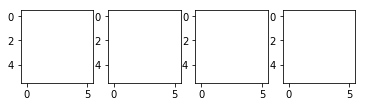

Layer number: 1
0.25834617
0.27540976
0.25834617
0.27540976
0.25834617
0.27540976
0.25834617
0.27540976


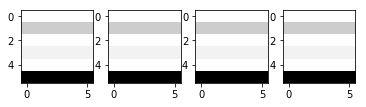

In [37]:
#@title Encoder attention at different layers

attention_mat = q_presence_mats

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


for layer in np.arange(len(attention_mat)):
  print("Layer number: %d" %layer)
  axes = {}
  for head in np.arange(1,hparams.num_heads+1):
    print(np.min(attention_mat[layer][0][head-1]))
    print(np.max(attention_mat[layer][0][head-1]))
    axes[head] = plt.subplot(1,4,head)
    im = axes[head].imshow(attention_mat[layer][0][head-1],cmap=plt.cm.binary)
  plt.show()

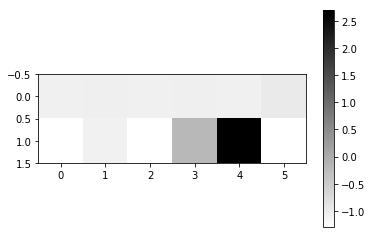

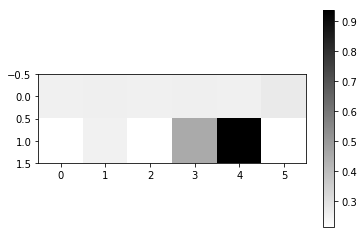

In [38]:
#@title Encoder presence prob at different layers

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


plt.imshow(presence_qz_logits[:,0], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

plt.imshow(presence_qz[:,0], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

Layer number: 0


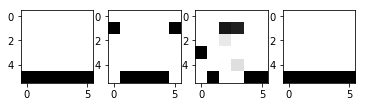

Layer number: 1


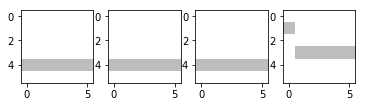

In [39]:
#@title Encoder assignment logits

attention_mat = assignment_weights

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


for layer in np.arange(len(attention_mat)):
  print("Layer number: %d" %layer)
  axes = {}
  for head in np.arange(1,5):
    axes[head] = plt.subplot(1,4,head)
    im = axes[head].imshow(attention_mat[layer][0][head-1],cmap=plt.cm.binary, vmin=0, vmax=1)
  plt.show()

[0.25834617 0.26168653 0.25842217 0.25922695 0.25846264 0.27540976]


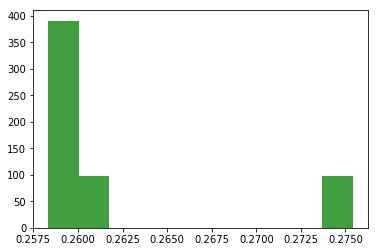

[0.21376705 0.2534512  0.2137698  0.45421776 0.93713945 0.21376707]


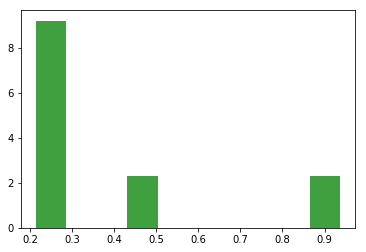

In [44]:
for layer in np.arange(len(presence_qz[:,0])):
    print(presence_qz[layer,0])
    n, bins, patches = plt.hist(presence_qz[layer,0], 10, density=True, facecolor='g', alpha=0.75)
    plt.show()